In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import the necessary packages
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path
from collections import Counter

In [2]:
from tensorflow.keras.applications import MobileNet, MobileNetV2, MobileNetV3Small, MobileNetV3Large, VGG16
from tensorflow.keras.applications import EfficientNetV2S, ConvNeXtSmall, DenseNet121,ResNet50,InceptionV3,EfficientNetB0
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D,Flatten,Dropout
from tensorflow.keras.models import Model
from tensorflow import keras
from tensorflow.keras.applications.mobilenet import preprocess_input as mob_preprocess_input
from tensorflow.keras.applications.efficientnet import preprocess_input as eff_preprocess_input
from tensorflow.keras.applications.convnext import preprocess_input as conv_preprocess_input
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess_input


In [3]:
import tensorflow as tf

# Check available GPUs
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPUs are available:")
    for gpu in gpus:
        print(gpu)
else:
    print("No GPUs detected.")

GPUs are available:
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [4]:
#read label information
df = pd.read_csv('/kaggle/input/deepweeds/labels.csv')
df.head()

,Filename,Label,Species
0,20160928-140314-0.jpg,0,Chinee apple
1,20160928-140337-0.jpg,0,Chinee apple
2,20160928-140731-0.jpg,0,Chinee apple
3,20160928-140747-0.jpg,0,Chinee apple
4,20160928-141107-0.jpg,0,Chinee apple


In [5]:
df[['Species','Label']].groupby(by='Species').count().T

Species,Chinee apple,Lantana,Negative,Parkinsonia,Parthenium,Prickly acacia,Rubber vine,Siam weed,Snake weed
Label,1125,1064,9106,1031,1022,1062,1009,1074,1016


In [6]:
label2id = df[['Species','Label']].groupby(by='Species').min().to_dict()['Label']
id2label = {label2id[i]:i for i in label2id}
id2label

{0: 'Chinee apple',
 1: 'Lantana',
 8: 'Negative',
 2: 'Parkinsonia',
 3: 'Parthenium',
 4: 'Prickly acacia',
 5: 'Rubber vine',
 6: 'Siam weed',
 7: 'Snake weed'}

In [7]:
num_classes = len(df['Label'].unique())
num_classes

9

In [8]:
df1=df[['Filename','Label']]
df1['Label']=df['Label'].astype(int)
df1['Species'] = df1['Label'].map(id2label)
df1.head()

/tmp/ipykernel_23/2892309576.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Label']=df['Label'].astype(int)


,Filename,Label,Species
0,20160928-140314-0.jpg,0,Chinee apple
1,20160928-140337-0.jpg,0,Chinee apple
2,20160928-140731-0.jpg,0,Chinee apple
3,20160928-140747-0.jpg,0,Chinee apple
4,20160928-141107-0.jpg,0,Chinee apple


In [9]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df1, test_size=0.3, shuffle=True, random_state=23, stratify=df['Label'])
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)
len(train), len(test)

(12256, 5253)

In [10]:
df1['Species'].value_counts()

Species
Negative          9106
Chinee apple      1125
Siam weed         1074
Lantana           1064
Prickly acacia    1062
Parkinsonia       1031
Parthenium        1022
Snake weed        1016
Rubber vine       1009
Name: count, dtype: int64

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    #rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Set validation split
)

In [12]:
image_size = (224, 224)  # Change based on your model's requirements
batch_size = 64

In [13]:
img_dir='/kaggle/input/deepweeds/images'

In [14]:
# Train Data Generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train,
    directory=img_dir,
    x_col='Filename',
    y_col='Species',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'  # Use subset for training
)

Found 9805 validated image filenames belonging to 9 classes.


In [15]:
print("Class indices:", train_generator.class_indices)

Class indices: {'Chinee apple': 0, 'Lantana': 1, 'Negative': 2, 'Parkinsonia': 3, 'Parthenium': 4, 'Prickly acacia': 5, 'Rubber vine': 6, 'Siam weed': 7, 'Snake weed': 8}


In [16]:
# Validation Data Generator
validation_generator = train_datagen.flow_from_dataframe(
    dataframe=train,
    directory=img_dir,
    x_col='Filename',
    y_col='Species',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'  # Use subset for validation
)

Found 2451 validated image filenames belonging to 9 classes.


In [17]:
print("Class indices:", validation_generator.class_indices)

Class indices: {'Chinee apple': 0, 'Lantana': 1, 'Negative': 2, 'Parkinsonia': 3, 'Parthenium': 4, 'Prickly acacia': 5, 'Rubber vine': 6, 'Siam weed': 7, 'Snake weed': 8}


In [18]:
# Create ImageDataGenerator for test (no augmentation)
test_datagen = ImageDataGenerator(
    #rescale=1./255
    )

In [19]:
# Test Data Generator
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test,
    directory=img_dir,
    x_col='Filename',
    y_col='Species',  # Assuming test data might still have labels, if not, use None
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',  # Use 'None' if no labels are available
    shuffle=False  # Important for test data to maintain order
)

Found 5253 validated image filenames belonging to 9 classes.


In [20]:
#from tensorflow.keras.applications.vgg16 import preprocess_input
def buildModel(IMG_SIZE, trainable=True,base_model='VGG',num_classes=num_classes):
    # Load the MobileNet model with weights pre-trained on ImageNet.
    #base_model, pooler = MobilenetV3Base((224,224,3), use='S')
    if(base_model=='Mobilenet'):
        base_model=MobileNet(IMG_SIZE, include_top=False, weights='imagenet')
        inputs = keras.Input(shape=IMG_SIZE, name='input')
        x=mob_preprocess_input(inputs)
        x = base_model(x, training=False)
    if (base_model=='DenseNet121'):
        base_model=DenseNet121(include_top=False, weights='imagenet',input_shape=IMG_SIZE)
        inputs = keras.Input(shape=IMG_SIZE, name='input')
        #x=vgg_preprocess_input(inputs)
        #x=inputs
        x = base_model(inputs)
    if(base_model=='ResNet50'):
        base_model=ResNet50(include_top=False, weights='imagenet',input_shape=IMG_SIZE)
        inputs = keras.Input(shape=IMG_SIZE, name='input')
        #x=vgg_preprocess_input(inputs)
        #x=inputs
        x = base_model(inputs)
    if (base_model=='InceptionV3'):
        base_model=InceptionV3(include_top=False, weights='imagenet',input_shape=IMG_SIZE)
        inputs = keras.Input(shape=IMG_SIZE, name='input')
        #x=vgg_preprocess_input(inputs)
        #x=inputs
        x = base_model(inputs)
    if (base_model=='EfficientNetB0'):
        base_model=EfficientNetB0(include_top=False, weights='imagenet',input_shape=IMG_SIZE)
        inputs = keras.Input(shape=IMG_SIZE, name='input')
        #x=vgg_preprocess_input(inputs)
        #x=inputs
        x = base_model(inputs)
    else:
        base_model=VGG16(include_top=False, weights='imagenet',input_shape=IMG_SIZE)
        inputs = keras.Input(shape=IMG_SIZE, name='input')
        #x=vgg_preprocess_input(inputs)
        x=inputs
        x = base_model(x)

    base_model.trainable = trainable


    print("Base Model:", base_model.name)
    print(len(base_model.layers))
    # Define the input layer.


    # Pre-process the input.
#     x = layers.Rescaling(1./255, name='PP_Rescale')(inputs)
#     x = layers.Resizing(224, 224, name='PP_Resize')(x)

    #x = augment(seed)(x)

    x = GlobalAveragePooling2D()(x)
    #x = Dropout(0.3)(x)
    #x=Dense(256,activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model_name = "Deepweed-" + base_model.name
    # Create the model.
    model = Model(inputs=inputs, outputs=outputs, name=model_name)

    return model

In [21]:
model = buildModel(image_size +(3,), trainable=True,base_model='EfficientNetB0',num_classes=num_classes)
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Base Model: efficientnetb0
238


Model: "Deepweed-efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 9)              │        11,529 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,061,100 (15.49 MB)

 Trainable params: 4,019,077 (15.33 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [22]:
model.name

'Deepweed-efficientnetb0'

In [23]:
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
# Constant for epochs
EPOCHS = 40

pat_es = 5
early_stopping = EarlyStopping(monitor='val_loss', patience=pat_es, verbose=1, restore_best_weights=True)
reduce_lr =ReduceLROnPlateau(monitor='val_loss',factor=0.75, patience=3, verbose=1, min_lr=1e-6)

model.compile(loss='categorical_crossentropy',
          optimizer= AdamW(learning_rate=2e-4,  weight_decay=5e-2),
          metrics=['accuracy'])

In [24]:
# Define your folder to save results
import os
save_folder = model.name
os.makedirs(save_folder, exist_ok=True)

In [25]:
filename= model.name+'.h5'
model_weight= os.path.join(save_folder, filename)
model_weight

'Deepweed-efficientnetb0/Deepweed-efficientnetb0.h5'

In [26]:
%%time
# Train the model
history1 = model.fit(
      train_generator,
      epochs=EPOCHS,
      validation_data=validation_generator,
      callbacks=[early_stopping, reduce_lr],
    )

Epoch 1/40


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1724465434.148908      66 service.cc:145] XLA service 0x7967a0003720 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724465434.148973      66 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1724465488.683945      66 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


154/154 ━━━━━━━━━━━━━━━━━━━━ 364s 2s/step - accuracy: 0.5482 - loss: 1.3398 - val_accuracy: 0.6520 - val_loss: 1.4638 - learning_rate: 2.0000e-04
Epoch 2/40
154/154 ━━━━━━━━━━━━━━━━━━━━ 178s 1s/step - accuracy: 0.8754 - loss: 0.3853 - val_accuracy: 0.7936 - val_loss: 0.7880 - learning_rate: 2.0000e-04
Epoch 3/40
154/154 ━━━━━━━━━━━━━━━━━━━━ 177s 1s/step - accuracy: 0.9157 - loss: 0.2492 - val_accuracy: 0.9155 - val_loss: 0.2339 - learning_rate: 2.0000e-04
Epoch 4/40
154/154 ━━━━━━━━━━━━━━━━━━━━ 178s 1s/step - accuracy: 0.9325 - loss: 0.1897 - val_accuracy: 0.9270 - val_loss: 0.2272 - learning_rate: 2.0000e-04
Epoch 5/40
154/154 ━━━━━━━━━━━━━━━━━━━━ 173s 1s/step - accuracy: 0.9455 - loss: 0.1530 - val_accuracy: 0.9396 - val_loss: 0.1802 - learning_rate: 2.0000e-04
Epoch 6/40
154/154 ━━━━━━━━━━━━━━━━━━━━ 175s 1s/step - accuracy: 0.9572 - loss: 0.1248 - val_accuracy: 0.9319 - val_loss: 0.1951 - learning_rate: 2.0000e-04
Epoch 7/40
154/154 ━━━━━━━━━━━━━━━━━━━━ 173s 1s/step - accuracy: 0.96

In [27]:
print("Saving the Model")
model.save(model_weight)

Saving the Model


In [28]:
#image visualization
import matplotlib.pyplot as plt
def plot_loss_acc(history):
    '''Plots the training and validation loss and accuracy from a history object'''
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']
    if 'peaks' in history:
        peaks = history['peaks']
    else:
        _min = np.argmin(val_loss)
        peaks = [_min]

    epochs = range(len(acc))
    print("Total Epochs:",epochs)

    plt.figure(figsize=[16, 4])
    plt.subplot(1,2,1)
    p_value = [val_acc[p] for p in peaks]
    plt.scatter(peaks, p_value, marker='o',s=50)
    plt.plot(epochs, acc, label='Training accuracy', color='red')
    plt.plot(epochs, val_acc, label='Validation accuracy', color='magenta')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    p_value = [val_loss[p] for p in peaks]
    plt.scatter(peaks, p_value, marker='o',s=50)
    plt.plot(epochs, loss, label='Training Loss', color='red')
    plt.plot(epochs, val_loss, label='Validation Loss', color='magenta')
    plt.title('Training and validation loss')
    plt.legend()
    plt.savefig(os.path.join(save_folder, 'training_chart.png'))
    plt.show()

Total Epochs: range(0, 28)


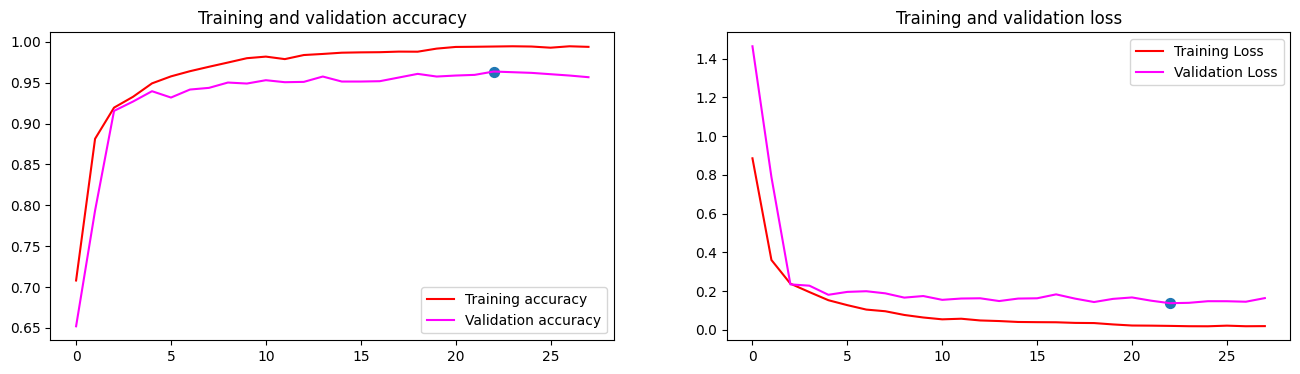

In [29]:
# Plot training results
plot_loss_acc(history1.history)

In [30]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

In [31]:
predictions=model.predict(test_generator)

83/83 ━━━━━━━━━━━━━━━━━━━━ 50s 545ms/step


In [32]:
import numpy as np
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)
# Get true labels from the test generator
true_labels = test_generator.classes
# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_classes)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[ 288   14    9    0    8    1    0    3   14]
 [   1  314    1    0    0    0    0    0    3]
 [  21  109 2541    3    8    7    4   24   15]
 [   0    1    5  290    1   12    0    0    0]
 [   1    0    2    2  300    1    1    0    0]
 [   1    2   16    1    9  287    1    0    2]
 [   2    9   11    0    0    0  281    0    0]
 [   0    3    0    0    0    0    1  318    0]
 [   6   25   11    0    0    0    0    2  261]]


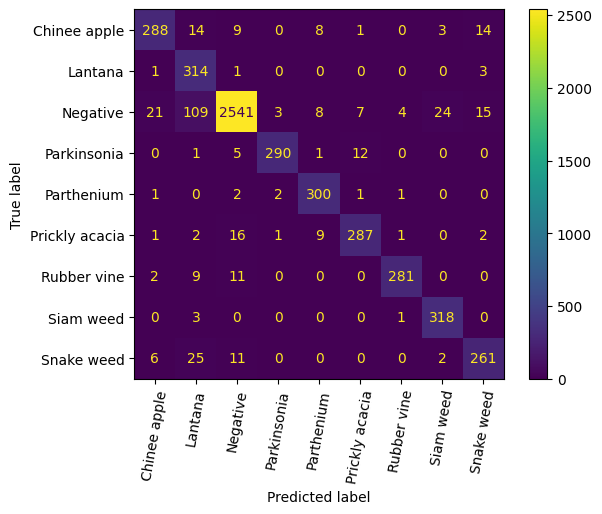

In [33]:
cmd = ConfusionMatrixDisplay.from_predictions(
        true_labels, predicted_classes,
        display_labels=list(test_generator.class_indices.keys()),
        xticks_rotation=80, #'vertical',
        # ax = ax
    )
    # fig, ax = plt.subplots(figsize=(25,5))
    # cmd.plot(ax=ax)
plt.savefig(os.path.join(save_folder, 'confusion-mat.png'))
plt.show()

In [34]:
display_labels=list(test_generator.class_indices.keys())
class_report=classification_report(true_labels, predicted_classes,digits=5, target_names=display_labels)
print(class_report)
with open(os.path.join(save_folder, 'classification_report.txt'), 'w') as f:
    f.write(classification_report(true_labels, predicted_classes))

                precision    recall  f1-score   support

  Chinee apple    0.90000   0.85460   0.87671       337
       Lantana    0.65828   0.98433   0.78894       319
      Negative    0.97881   0.93009   0.95383      2732
   Parkinsonia    0.97973   0.93851   0.95868       309
    Parthenium    0.92025   0.97720   0.94787       307
Prickly acacia    0.93182   0.89969   0.91547       319
   Rubber vine    0.97569   0.92739   0.95093       303
     Siam weed    0.91643   0.98758   0.95067       322
    Snake weed    0.88475   0.85574   0.87000       305

      accuracy                        0.92899      5253
     macro avg    0.90508   0.92835   0.91257      5253
  weighted avg    0.93860   0.92899   0.93125      5253

